In [43]:
# iqf = 2e6

In [44]:
import math
import serial
import serial.tools.list_ports
from dataclasses import dataclass
from bitstring import BitArray
import numpy as np
from typing import *

# list available ports
# ports = list(serial.tools.list_ports.comports())
# for p in ports:
#     print(p.device, p.description)

ser = serial.Serial('COM8', baudrate=2e6, timeout=2)  # timeout in seconds
print("Port opened:", ser.is_open)

startSeq = b'[DB,'
expectedCount: Optional[int] = 2

response = b''
try:
    lastCountPrinted = 0
    while True:
        response += ser.read_all()
        nBuffers = response.count(startSeq)
        if nBuffers > lastCountPrinted:
            print(f"\rRead {nBuffers} buffers")
            lastCountPrinted = nBuffers

        if expectedCount is not None and nBuffers >= expectedCount:
            break
except KeyboardInterrupt:
    pass
finally:
    ser.close()

    
if response.find(b'COMMAND_REJECTED') != -1:
    print("Warning: COMMAND_REJECTED found in response")

print("Read", len(response), "bytes")

@dataclass
class Buffer:
    label: str
    length: int
    granularity: int
    iq: np.ndarray

# [DBA,2028,4=....]
def parseBuffer(raw: bytes, x: int) -> tuple[Buffer, int]:
    x += 1  # skip '['

    label = ''
    while raw[x] != ord(','):
        label += chr(raw[x])
        x += 1
    x += 1

    length = ''
    while raw[x] != ord(','):
        length += chr(raw[x])
        x += 1
    length = int(length)
    x += 1

    granularity = ''
    while raw[x] != ord('='):
        granularity += chr(raw[x])
        x += 1
    granularity = int(granularity)
    x += 1

    nBytes = math.ceil((length * 2 * granularity) / 8)
    bits = BitArray(bytes=raw[x:x+nBytes])

    # Build a numpy array of shape (length, 2). Use int32 to avoid overflow issues.
    values: list[tuple[int, int]] = []
    rescale = 1 << (16 - granularity)
    for bitslice in bits.cut(granularity * 2):
        i_val = bitslice[0:granularity].int * rescale
        q_val = bitslice[granularity:granularity*2].int * rescale
        values.append((i_val, q_val))
    IQ_array = np.asarray(values, dtype=np.int16)
    x += nBytes + 1

    return Buffer(
        label,
        length,
        granularity,
        IQ_array
    ), x

IQ = np.empty((0, 2), dtype=np.int16)
i = 0
n = 0
while True:
    i = response.find(startSeq, i)
    if i == -1:
        break
    n += 1
    try:
        buf, i = parseBuffer(response, i)
        # stack buffer IQ arrays vertically into the global IQ array
        if buf.iq.size:
            IQ = np.vstack((IQ, buf.iq))
    except ValueError, IndexError:
        print("Last buffer incomplete")
        break

print("Parsed", n, "buffers,", len(IQ), "IQ pairs total")


Port opened: True
Read 1 buffers
Read 2 buffers
Read 8306 bytes
Parsed 2 buffers, 2052 IQ pairs total


In [45]:
IQ_REF = IQ
%store IQ_REF

Stored 'IQ_REF' (ndarray)


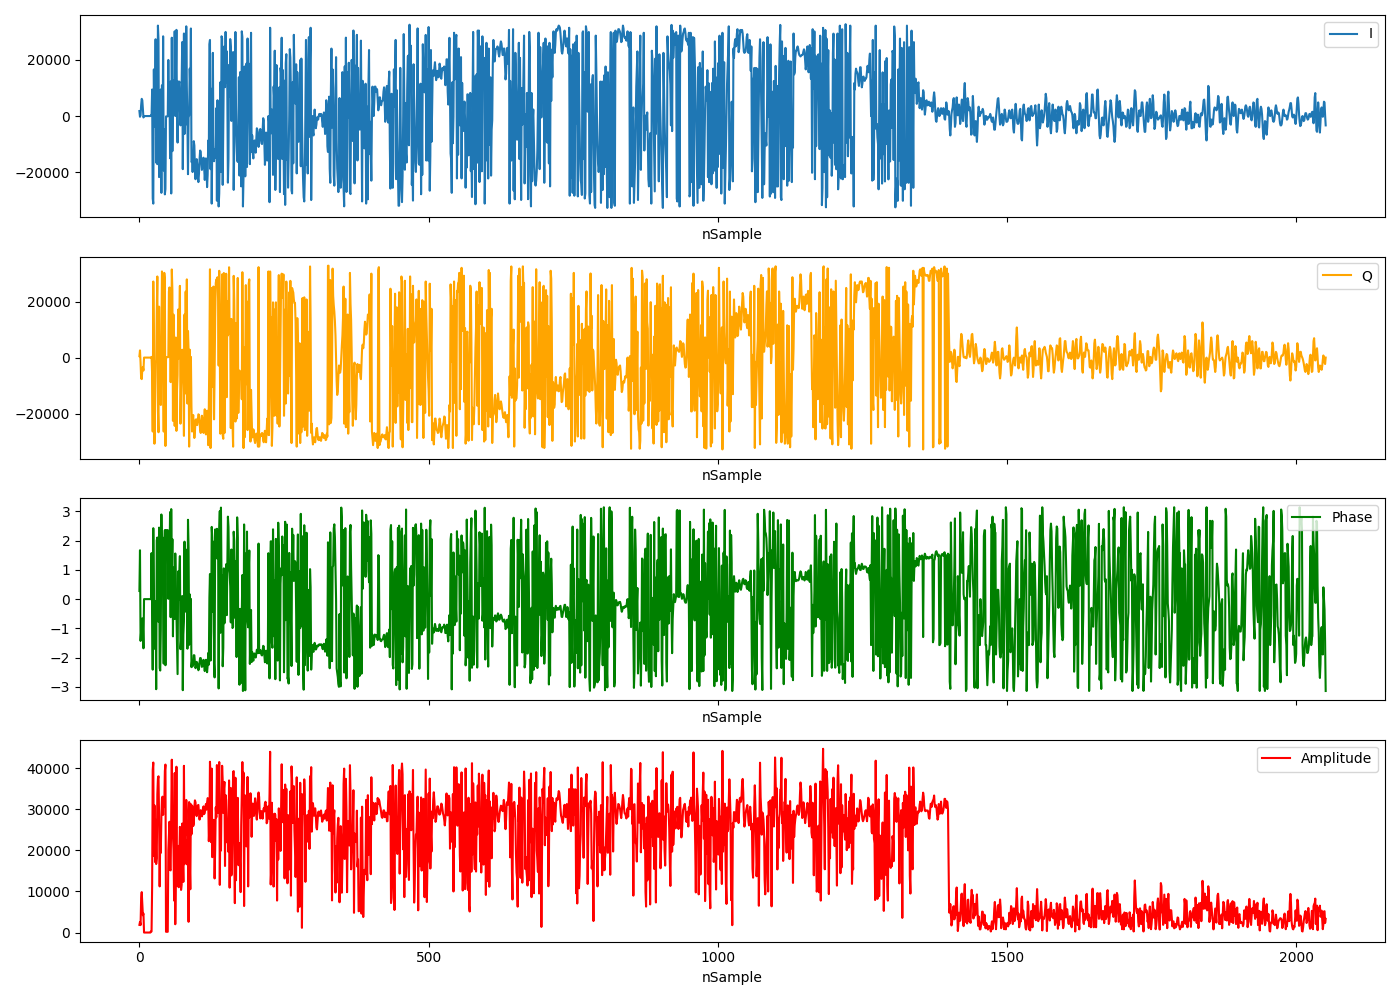

In [46]:
%matplotlib widget
import matplotlib.pyplot as plt
import math

# IQ is now a numpy array with shape (N, 2)
I = IQ[:, 0]
Q = IQ[:, 1]
phase = np.arctan2(Q, I)
A = np.hypot(I, Q)

try:
    microSecondsPerSample = 1e6 / iqf
    time = [i * microSecondsPerSample for i in range(len(IQ))]
    timeLabel = 'Time (µs)'
except NameError:
    time = list(range(len(IQ)))
    timeLabel = 'nSample'

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(14, 10))
axs: list[plt.Axes]
(ax1, ax2, ax3, ax4) = axs
ax1.plot(time, I, label='I')
ax1.legend(loc='upper right')
ax2.plot(time, Q, label='Q', color='orange')
ax2.legend(loc='upper right')
ax3.plot(time, phase, label='Phase', color='green')
ax3.legend(loc='upper right')
ax4.plot(time, A, label='Amplitude', color='red')
ax4.legend(loc='upper right')

for ax in axs:
    # ax.axvline(time[len(DBA)+finish[1]], color='gray', linestyle='--')
    ax.set_xlabel(timeLabel)

plt.tight_layout()
plt.show()
